In [1]:
import torch
import torch as th
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss
from torchmetrics import ScaleInvariantSignalNoiseRatio

In [2]:
data_train = my_dataset('./beam_data/train')

fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

train_target, train_sample, train_noise = data_train[0]
spec_noise = stft.stft(train_noise[None])

In [3]:
def pipeline(model, spec):
    magn = spec.abs()
    phase = spec.angle()
    mask = model(torch.log(magn+1e-5))
    mag_predict = magn * mask
#     z = torch.polar(mag_predict, phase)
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)
    z = th.complex(real, imag)
    return z

In [4]:
torch.manual_seed(1)


crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

epochs = 1000
model = Unet_model()

optim = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )
si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
    
    z = pipeline(model, spec_noise)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    #print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.85it/s]


min loss: 0.7150565981864929


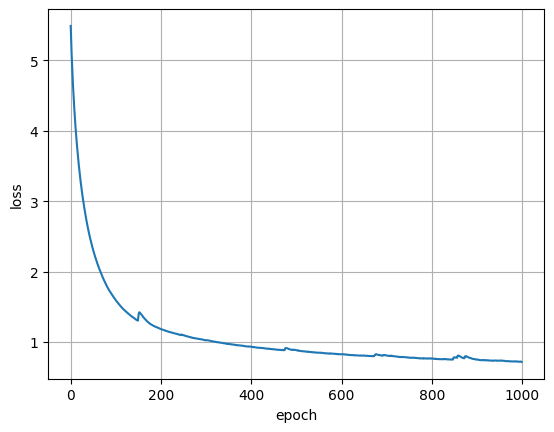

max metric: 18.31576156616211


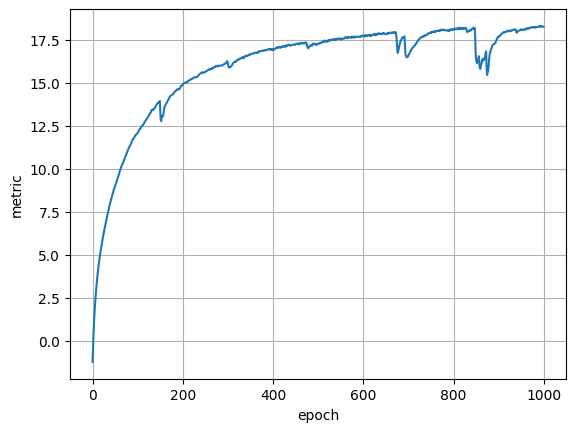

In [5]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);
plt.show()
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

# Audio

In [6]:
from IPython.display import Audio

In [7]:
print('Предикт')
Audio(wave_predict[0].detach(), rate=16000)

Предикт


In [8]:
print('С шумом')
Audio(train_noise.detach(), rate=16000)

С шумом


In [9]:
print('Таргет')
Audio(train_target[0].detach(), rate=16000)

Таргет


# Spec

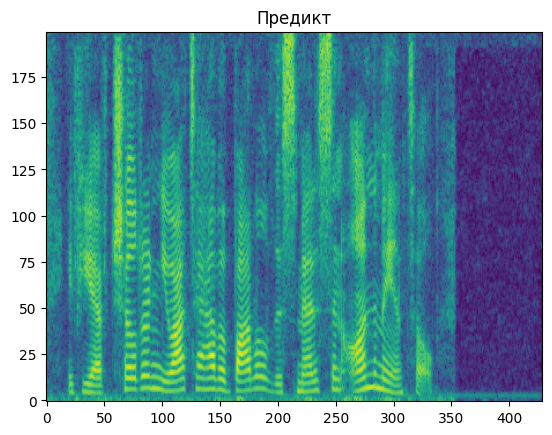

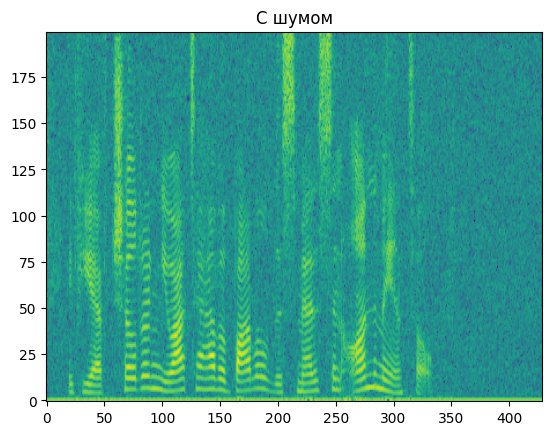

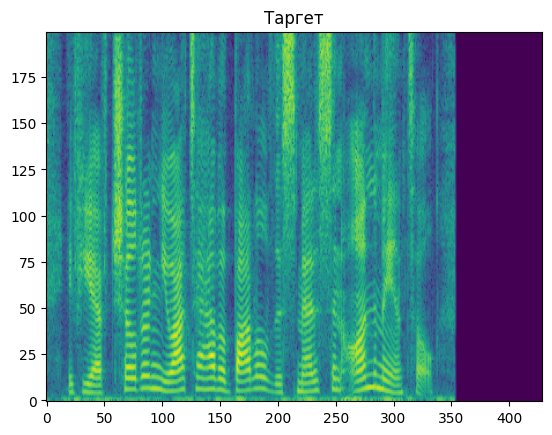

In [10]:
plt.title('Предикт')
plt.imshow(torch.log(stft.stft(wave_predict[0]).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('С шумом')
plt.imshow(torch.log(stft.stft(train_noise).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('Таргет')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

# Mask

In [11]:
def pipeline_mask(model, spec):
    magn = spec.abs()
    phase = spec.angle()
    mask = model(torch.log(magn+1e-5))
    mag_predict = magn * mask
#     z = torch.polar(mag_predict, phase)
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)
    z = th.complex(real, imag)
    return magn, mask, z

def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

In [12]:
magn, mask, z = pipeline_mask(model, spec_noise)


Это то что выдает модель после обучения. Можно видеть, что значения в принципе могут быть не ограничены.
MVDR работает с маской со значениями [0, 1]

tensor([[-0.1517, -0.3183, -0.2551,  ..., -0.1774, -0.1495, -0.1532],
        [ 0.2187,  0.0856, -0.1581,  ...,  0.4146,  0.2972,  0.2488],
        [ 0.1415,  0.0047, -0.0416,  ...,  0.4969,  0.4473,  0.4322],
        ...,
        [ 0.5742,  0.5187,  0.0387,  ..., -0.1460, -0.2163, -0.1740],
        [ 0.1212,  0.4034,  0.7275,  ...,  0.1063,  0.1532,  0.0238],
        [-0.1736,  0.0050,  0.6713,  ..., -0.0092, -0.0104, -0.0745]])


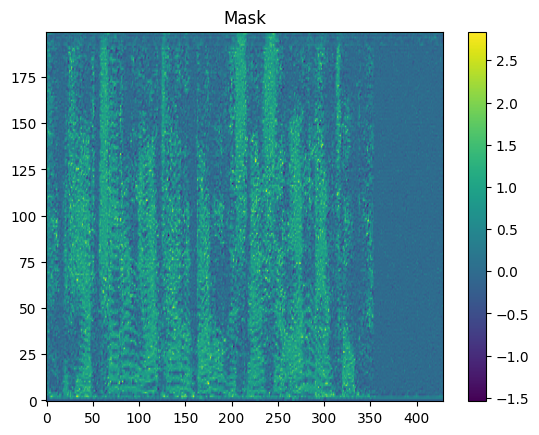

In [13]:
print("""
Это то что выдает модель после обучения. Можно видеть, что значения в принципе могут быть не ограничены.
MVDR работает с маской со значениями [0, 1]
""")
print((mask).detach()[0][0])
plot_mask(mask.detach()[0][0], 'Mask')
plt.show();


Это если мы применим, сигмоиду -> [0, 1] mvdr
Это не работает, т.к. модель учит давать наименьшее значение шуму, после сигмоиды эти значения уходят в ~0.5

tensor([[0.4622, 0.4211, 0.4366,  ..., 0.4558, 0.4627, 0.4618],
        [0.5545, 0.5214, 0.4605,  ..., 0.6022, 0.5738, 0.5619],
        [0.5353, 0.5012, 0.4896,  ..., 0.6217, 0.6100, 0.6064],
        ...,
        [0.6397, 0.6268, 0.5097,  ..., 0.4636, 0.4461, 0.4566],
        [0.5303, 0.5995, 0.6742,  ..., 0.5266, 0.5382, 0.5059],
        [0.4567, 0.5012, 0.6618,  ..., 0.4977, 0.4974, 0.4814]])


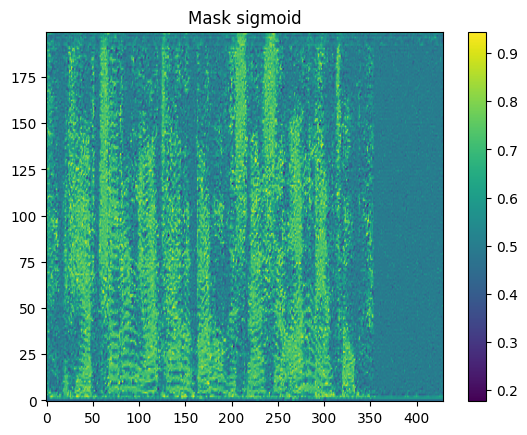

In [14]:
print("""
Это если мы применим, сигмоиду -> [0, 1] mvdr
Это не работает, т.к. модель учит давать наименьшее значение шуму, после сигмоиды эти значения уходят в ~0.5
""")
print(F.sigmoid(mask).detach()[0][0])
plot_mask(F.sigmoid(mask).detach()[0][0], 'Mask sigmoid')
plt.show();


Я придумал очень простой ход:
        / 1, x >= 1
f(x) = {  x, 0 < x < 1
        \ 0 , x <= 0
И это работает!

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1679, 0.0661, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0211, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2941, 0.2076, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1051, 0.3380,  ..., 0.0915, 0.0915, 0.0915],
        [0.0000, 0.0000, 0.2077,  ..., 0.0000, 0.0000, 0.0000]])


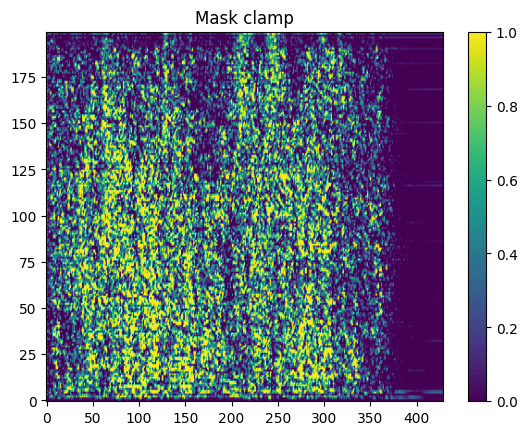

In [44]:
print("""
Я придумал очень простой ход:
        / 1, x >= 1
f(x) = {  x, 0 < x < 1
        \ 0 , x <= 0
И это работает!
""")
print(mask.clamp(0, 1).detach()[0][0])
plot_mask(mask.clamp(0, 1).detach()[0][0], 'Mask clamp')
plt.show();

Белые пиксели в 'Магнитуда с маской' это из-за magn*mask, 
т.к mask принимает любые значения и может так получится, что magn*mask<0 -> log->nan



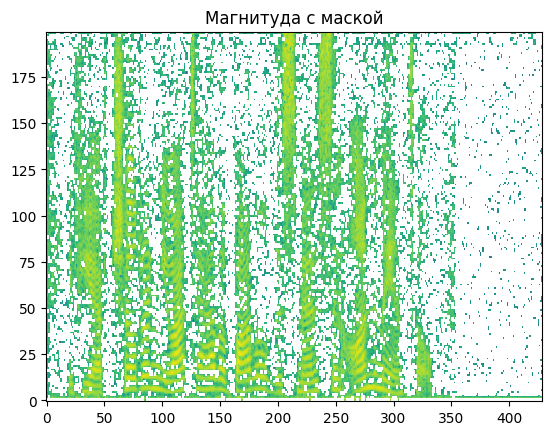

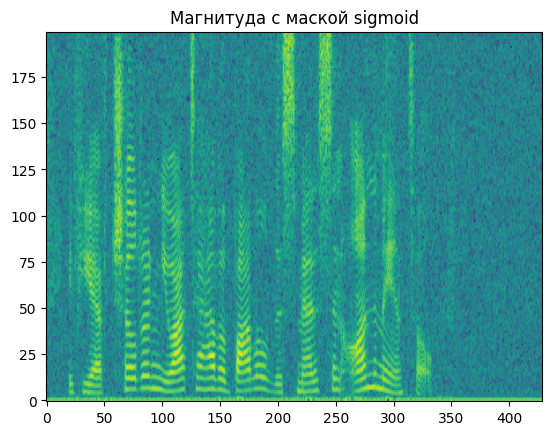

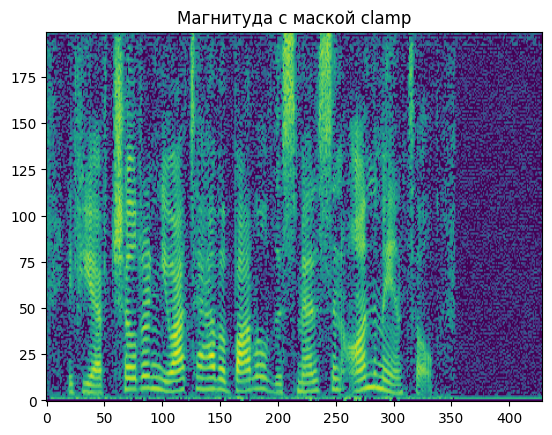

In [16]:
print("""Белые пиксели в 'Магнитуда с маской' это из-за magn*mask, 
т.к mask принимает любые значения и может так получится, что magn*mask<0 -> log->nan
""")
plt.title('Магнитуда с маской')
plt.imshow(torch.log(magn*mask+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('Магнитуда с маской sigmoid')
plt.imshow(torch.log(magn*F.sigmoid(mask)+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('Магнитуда с маской clamp')
plt.imshow(torch.log(magn*mask.clamp(0, 1)+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

# test MVDR

## училось всё на удаление шума, дальше тест идет на комнате где 4 микрофна с RIR.

In [38]:
mvdr = MVDR(0)

In [18]:
# поиск опорного канала
spec_sample = stft.stft(train_sample[None])
power_spec = spec_sample.abs()**2

mean_spec_power = power_spec.mean(dim=(-1, -2)) # беру среднее по F и по T
ref_channel = torch.argmax(mean_spec_power, dim=1) # индекс канала, где в среднем самый мощный сигнал
ref_sample_mic = spec_sample[:,ref_channel] # референс канал

In [19]:
magn, mask, z = pipeline_mask(model, ref_sample_mic) # находим маску рееренсного канала

In [20]:
wave_predict_model = stft.istft(z, train_sample.shape[-1])

In [39]:
z_mvd = mvdr(spec_sample, mask[0].clamp(0, 1))
wave_predict_mvd = stft.istft(z_mvd, train_sample.shape[-1])

In [40]:
print("""RIR: model predict
""")
Audio(wave_predict_model[0].detach(), rate=16000)

RIR: model predict



In [41]:
print("""RIR: MVDR predict
""")
Audio(wave_predict_mvd[0].detach(), rate=16000)

RIR: MVDR predict



In [42]:
print("""RIR: microphone
""")
Audio(train_sample[ref_channel], rate=16000)

RIR: microphone



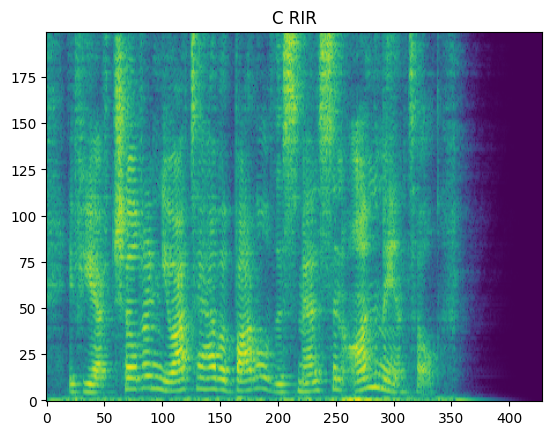

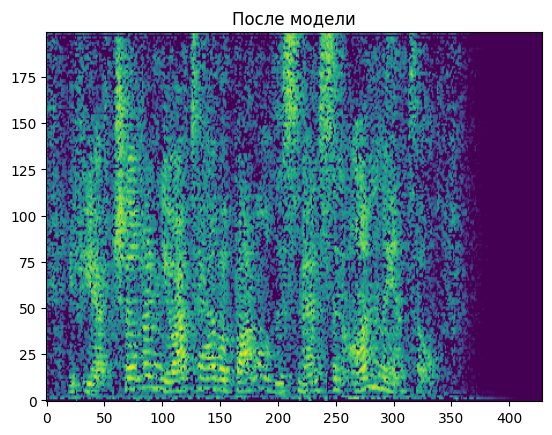

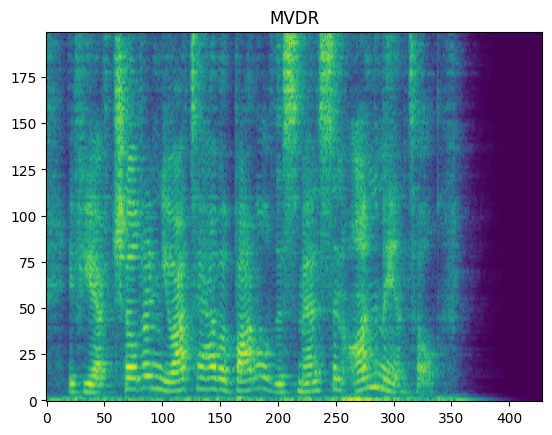

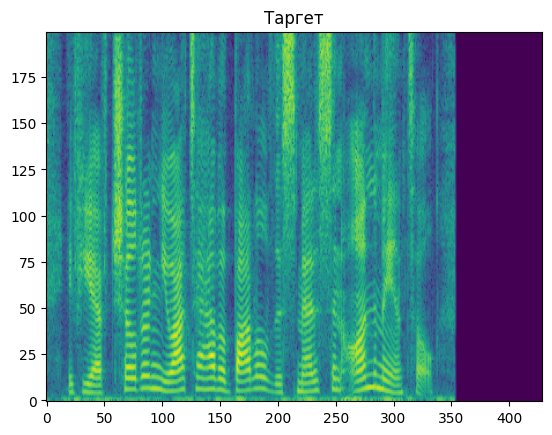

In [43]:
plt.title('С RIR')
plt.imshow(torch.log(ref_sample_mic.abs()+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('После модели')
plt.imshow(torch.log(magn*(mask.clamp(0, 1))+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('MVDR')
plt.imshow(torch.log(stft.stft(wave_predict_mvd).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto")
plt.show();

plt.title('Таргет')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto")
plt.show();